In [1]:
import pandas as pd
import shapely
import numpy as np
import sys
import torch
import argparse
import random
import math
import os
import warnings
from datetime import datetime
from gensim.models import word2vec
from shapely.geometry import LineString, Polygon
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler# 好处在于可以保存训练集中的参数（均值、方差）
from scipy.stats import stats
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
import gc
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# load data
df = pd.read_csv('../data/Artikelbewegungen ab 1996.txt', sep=';', encoding = 'ISO-8859-1', header=None)
#df = pd.read_excel('../data/Artikelbewegungen.xlsx')

In [3]:
columns = ["Bew_Typ", "BewSchl", "BewTxt", "BewSchl2", "LagerOrt", "Art_Typ", "ArtGrp", "ArtNr", "Bew_Datum", "Bew_Jahr", "Bew_Monat", "Menge", "EinheitNr", "Einheit", "Lief_Kd_Nr", "Best_Auft_Nr"]

In [4]:
df.columns = columns

In [5]:
df.head()

,Bew_Typ,BewSchl,BewTxt,BewSchl2,LagerOrt,Art_Typ,ArtGrp,ArtNr,Bew_Datum,Bew_Jahr,Bew_Monat,Menge,EinheitNr,Einheit,Lief_Kd_Nr,Best_Auft_Nr
0,Take On,0,NaN,TO,11,FW,8,8030696,1996/1/1 0:00:00,1996,1,500.000,23,kg,nan,0.000
1,Take On,0,NaN,TO,0,FW,8,8030725,1996/1/1 0:00:00,1996,1,175.000,23,kg,nan,0.000
2,Take On,0,NaN,TO,11,FW,8,8030725,1996/1/1 0:00:00,1996,1,450.000,23,kg,nan,0.000
3,Take On,0,NaN,TO,11,FW,8,8030796,1996/1/1 0:00:00,1996,1,1000.000,23,kg,nan,0.000
4,Take On,0,NaN,TO,0,FW,8,8030825,1996/1/1 0:00:00,1996,1,125.000,23,kg,nan,0.000


# Interesting data
only view same importance features: Bew_Datum(>2005), Menge(only), ArtNr, ArtGrp
### Data filter
- Data filter: Bew_Datum(>2005), Menge(only ), ArtNr(first 6), ArtGrp(1-19)
- the menge features of the verkauf data should be negative, but there are 3506(of 389176) positve found in the dataset
- exist duplications

### Change Menge to positive
### plot number of record je ArtNr
- most article has less than 3000 records(only 24 items excess this number), which means, they don't have enough data to train the model
- for ArtNr 205002(in 4th place), which habe 6970 records, only has records in 2002 different days from 2848 days(from 2005 to 2013), In 30% Datum ist this value Null.

### detect extrem value in each features
- min value of Menge is 0.1, is it right? what is the min value of Menge normally

### plot the trend of Menge for article
- can not find the trend manual
- long tride means they rest in janural 

### fill lack data and plot the trend again


df.iloc[636,:]

## Data filter

In [37]:
df = df[df['Bew_Jahr'] >= 2005][['Bew_Typ', 'Bew_Datum', 'Bew_Jahr', 'ArtNr', 'ArtGrp', 'Menge', 'Lief_Kd_Nr']]
df = df[df['Bew_Typ'] == 'Verkauf']
df = df[df['ArtGrp'] < 20]
df['ArtNr'] = df['ArtNr'].map(lambda x: str(x)[:6])
df['Bew_Datum'] = pd.to_datetime(df['Bew_Datum'], dayfirst=True)
#df['Menge'] = df['Menge'].map(lambda x: x.replace(',', '.'))
#df['Menge'] = pd.to_numeric(df['Menge'])  
df = df[df['Menge'] < 0]
df['weekday'] = df['Bew_Datum'].map(lambda x: x.weekday)

In [7]:
len(df.drop_duplicates())

532982

In [8]:
len(df)

547311

In [9]:
df = df.drop_duplicates()

In [36]:
df['Bew_Datum'].map(lambda x: x.weekday())

AttributeError: 'Timestamp' object has no attribute 'is_weekday'

## Change menge to positive

In [10]:
df['Menge'] = -df['Menge']

## Plot number of record je ArtNr

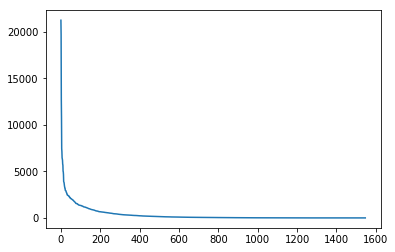

In [11]:
tmp = df['ArtNr'].value_counts()
tmp = tmp.to_list()
plt.plot(tmp)

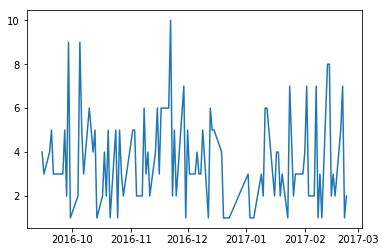

In [12]:
df['count'] = 1
tmp = df[df['ArtNr'] == '205002'][['Bew_Datum', 'count']].groupby('Bew_Datum').sum()
plt.plot(tmp[2500:2600])

In [13]:
df['count'] = 1
tmp = df[df['ArtNr'] == '904223'][['Bew_Datum', 'count']].groupby('Bew_Datum').sum()

In [14]:
len(tmp)

2741

In [15]:
df['ArtNr'].value_counts()

200032    21236
201612    19676
904213    12692
205002    10729
120100     7460
102012     7125
230112     6457
904223     6353
410102     6220
412032     5781
412012     5681
804602     5016
201312     4957
824122     4647
180426     3906
230212     3828
824159     3791
200072     3575
905122     3435
180464     3331
180465     3205
850859     3196
121010     2997
824152     2936
850857     2924
200113     2919
101522     2886
100000     2769
102252     2738
604112     2701
          ...  
827222        1
191006        1
190842        1
802412        1
602062        1
101633        1
803049        1
193108        1
192111        1
101059        1
190311        1
817042        1
180511        1
200022        1
999022        1
180602        1
809412        1
110421        1
180503        1
191341        1
191995        1
163402        1
102313        1
193102        1
110424        1
146622        1
911223        1
163201        1
190564        1
191131        1
Name: ArtNr, Length: 154

### detect extrem value in each features

In [16]:
df.describe()

,Bew_Jahr,ArtGrp,Menge,Lief_Kd_Nr,count
count,532982.000,532982.000,532982.000,532982.000,532982.000
mean,2011.694,6.754,227.747,3016.373,1.000
std,4.161,4.484,425.275,1833.913,0.000
min,2005.000,1.000,0.100,1.000,1.000
25%,2008.000,2.000,50.000,1416.000,1.000
50%,2012.000,8.000,100.000,2882.000,1.000
75%,2015.000,9.000,225.000,5062.000,1.000
max,2019.000,19.000,13860.000,9900.000,1.000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 532982 entries, 478456 to 1374220
Data columns (total 8 columns):
Bew_Typ       532982 non-null object
Bew_Datum     532982 non-null datetime64[ns]
Bew_Jahr      532982 non-null int64
ArtNr         532982 non-null object
ArtGrp        532982 non-null int64
Menge         532982 non-null float64
Lief_Kd_Nr    532982 non-null float64
count         532982 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 36.6+ MB


## plot the trend of Menge for article

<Figure size 1440x720 with 0 Axes>

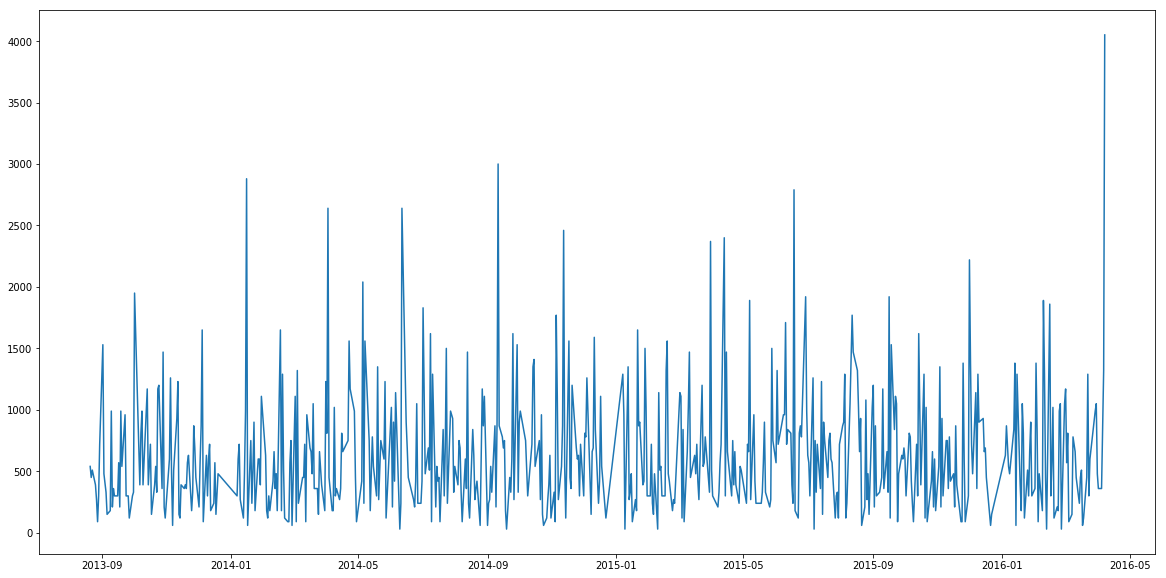

In [18]:
df['count'] = 1
tmp = df[df['ArtNr'] == '904213'][['Bew_Datum', 'Menge']].groupby('Bew_Datum').sum()
plt.figure(figsize=(20, 10))
plt.plot(tmp[2000:2600])
#plt.plot(tmp)

In [19]:
df['ArtNr'].value_counts()

200032    21236
201612    19676
904213    12692
205002    10729
120100     7460
102012     7125
230112     6457
904223     6353
410102     6220
412032     5781
412012     5681
804602     5016
201312     4957
824122     4647
180426     3906
230212     3828
824159     3791
200072     3575
905122     3435
180464     3331
180465     3205
850859     3196
121010     2997
824152     2936
850857     2924
200113     2919
101522     2886
100000     2769
102252     2738
604112     2701
          ...  
827222        1
191006        1
190842        1
802412        1
602062        1
101633        1
803049        1
193108        1
192111        1
101059        1
190311        1
817042        1
180511        1
200022        1
999022        1
180602        1
809412        1
110421        1
180503        1
191341        1
191995        1
163402        1
102313        1
193102        1
110424        1
146622        1
911223        1
163201        1
190564        1
191131        1
Name: ArtNr, Length: 154

## fill lack data and plot the trend again

In [20]:
# create empty grid
START_TIME = datetime(2005, 1, 1)
END_TIME = datetime(2019, 3, 29)
index_dax = pd.date_range(START_TIME, END_TIME,freq='D').date
df_grid = pd.DataFrame(index = index_dax)

In [ ]:
# choose the target article and agg the menge
df_200 = df[df['ArtNr'] == '200032'][['Bew_Datum', 'Menge']].groupby('Bew_Datum').sum()
# join two table
df_200 = df_grid.join(df_200, how = 'left')
# fill null with 0
df_200 = df_200.fillna(0)

<Figure size 1440x720 with 0 Axes>

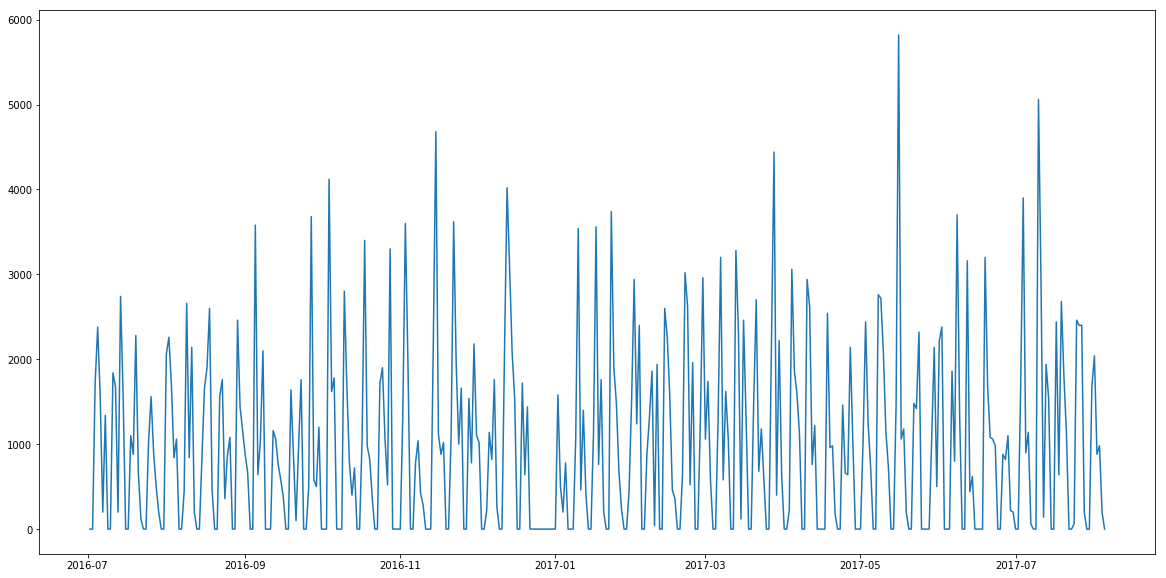

In [31]:
# plot 
plt.figure(figsize=(20, 10))
plt.plot(df_200[4200:4600])

In [29]:
pd.to_pickle(df_200, '../results/df_200.pkl')